In [19]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# To load the environment variable defined in the .env file
from dotenv import load_dotenv
load_dotenv();

import sys
import os
sys.path.append(os.path.join(os.environ['NHL_DATA_DIR'], '..'))

In [21]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.impute import SimpleImputer
import shap
from xgboost import XGBClassifier


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import src.features.build_features as FeaturesManager
import src.features.select_features as FeaturesSelector
import src.features.detect_outliers as OutliersManager

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)



In [7]:
seasons_year = [2015, 2016, 2017, 2018]
season_type = "Regular"
data_df = FeaturesManager.build_features(seasons_year, season_type, with_player_stats=True, with_strength_stats=True)

features_to_keep = FeaturesManager.GetFeaturesToKeep()

feature_names, target_name = features_to_keep[0:-1], features_to_keep[-1]
feature_names = np.array(feature_names)

df_features = data_df[feature_names]
df_targets = data_df[target_name]

X = df_features
y = df_targets

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

In [16]:
numerical_columns = [
    'Period seconds', 'st_X', 'st_Y', 'Shot distance', 'Shot angle', 
    'Speed From Previous Event', 'Change in Shot Angle', 
    'Shooter Goal Ratio Last Season', 'Goalie Goal Ratio Last Season',
    'Elapsed time since Power Play', 'Last event elapsed time', 'Last event st_X', 'Last event st_Y', 
    'Last event distance', 'Last event angle']

nominal_columns = ['Shot Type', 'Strength', 'Shooter Side', 'Shooter Ice Position']
ordinal_columns = ['Period', 'Num players With', 'Num players Against', 'Is Empty', 'Rebound']

In [22]:
# SHAP Analysis to find the best features

# median
fill_nan = ColumnTransformer(transformers = [
    ('cat', SimpleImputer(strategy ='most_frequent'), nominal_columns + ordinal_columns),
    ('num', SimpleImputer(strategy ='median'), numerical_columns),
], remainder ='passthrough')

# one-hot      
one_hot = ColumnTransformer(transformers = [
    ('enc', OneHotEncoder(sparse = False), list(range(len(nominal_columns)))),
], remainder ='passthrough')

xbg = XGBClassifier(random_state=RANDOM_SEED)
steps = [('fill_nan', fill_nan), ('one_hot', one_hot),  ("xbg", xbg)]
pipeline = Pipeline(steps=steps).fit(X, y)
    
# explain the model's predictions using SHAP
explainer = shap.Explainer(pipeline)
shap_values = explainer(X)

TypeError: The passed model is not callable and cannot be analyzed directly with the given masker! Model: Pipeline(steps=[('fill_nan',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['Shot Type', 'Strength',
                                                   'Shooter Side',
                                                   'Shooter Ice Position',
                                                   'Period', 'Num players With',
                                                   'Num players Against',
                                                   'Is Empty', 'Rebound']),
                                                 ('num',
                                                  SimpleImputer(strategy='median'),
                                                  ['Period seconds', 'st_X',
                                                   'st_Y', 'Shot distance',
                                                   'Shot an...
                               feature_types=None, gamma=0, gpu_id=-1,
                               grow_policy='depthwise', importance_type=None,
                               interaction_constraints='',
                               learning_rate=0.300000012, max_bin=256,
                               max_cat_threshold=64, max_cat_to_onehot=4,
                               max_delta_step=0, max_depth=6, max_leaves=0,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=0, num_parallel_tree=1, predictor='auto',
                               random_state=42, ...))])

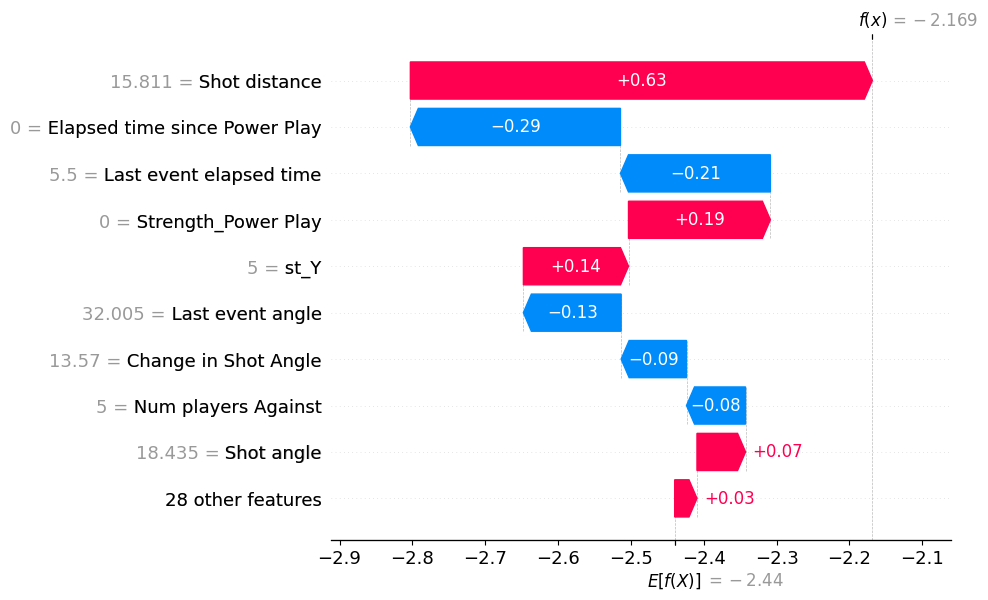

In [11]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])

In [24]:
from comet_ml import API
import pickle

api = API()
workspace_name = "ift6758-a22-g08"


# Download the Adaboost / Anova
api.download_registry_model(workspace_name, "adaboost-anova", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "Adaboost_Anova.pkl")
with open(pkl_filename, 'rb') as file:
    clf_adaboost_anova = pickle.load(file)


# Download the Random FOrest
api.download_registry_model(workspace_name, "randomforest", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "randomforest.pkl")
with open(pkl_filename, 'rb') as file:
    clf_random_forest = pickle.load(file) 
    
# Download the Knn / Linear SVC
api.download_registry_model(workspace_name, "knn-lasso", "1.0.0", output_path=os.environ["NHL_MODEL_DIR"], expand=True)
pkl_filename = os.path.join(os.environ["NHL_MODEL_DIR"], "KNN_Lasso.pkl")
with open(pkl_filename, 'rb') as file:
    clf_knn = pickle.load(file)

COMET INFO: Downloading registry model 'adaboost-anova', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'randomforest', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!
COMET INFO: Downloading registry model 'knn-lasso', version '1.0.0', stage None from workspace 'ift6758-a22-g08'...
COMET INFO: Unzipping model to '/mnt/d/GitHub/IFT6758-A2022-G08/models' ...
COMET INFO: done!


In [25]:
import src.models.HP_AdaBoost as HP_AdaBoost
import src.models.HP_RandomForest as HP_RandomForest
import src.models.HP_KNN as HP_KNN


X_train_adaboost, X_valid_adaboost, y_train_adaboost, y_valid_adaboost = HP_AdaBoost.GetTrainingData()
print(classification_report(y_valid_adaboost, clf_adaboost_anova.predict(X_valid_adaboost)))

X_train_forest, X_valid_forest, y_train_forest, y_valid_forest, _, _, _ = HP_RandomForest.GetTrainingData()
print(classification_report(y_valid_forest, clf_random_forest.predict(X_valid_forest)))

X_train_knn, X_valid_knn, y_train_knn, y_valid_knn = HP_KNN.GetTrainingData()
print(classification_report(y_valid_knn, clf_knn.predict(X_valid_knn)))

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     55434
         1.0       0.33      0.33      0.33      5574

    accuracy                           0.88     61008
   macro avg       0.63      0.63      0.63     61008
weighted avg       0.88      0.88      0.88     61008

              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93     55434
         1.0       0.34      0.38      0.36      5738

    accuracy                           0.87     61172
   macro avg       0.64      0.65      0.64     61172
weighted avg       0.88      0.87      0.88     61172

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.96     55434
         1.0       0.71      0.14      0.24      5574

    accuracy                           0.92     61008
   macro avg       0.81      0.57      0.60     61008
weighted avg       0.90      0.92      0.89     61008



In [29]:
from sklearn.calibration import CalibratedClassifierCV

# calibrated_clf_adaboost = CalibratedClassifierCV(base_estimator=clf_adaboost_anova, cv=3)
# calibrated_clf_adaboost.fit(X_valid_adaboost, y_valid_adaboost)

# calibrated_clf_forest = CalibratedClassifierCV(base_estimator=clf_random_forest, cv=3)
# calibrated_clf_forest.fit(X_valid_forest, y_valid_forest)

calibrated_clf_knn = CalibratedClassifierCV(base_estimator=clf_knn, cv=3)
calibrated_clf_knn.fit(X_valid_knn, y_valid_knn)


,Period,Period seconds,st_X,st_Y,Shot Type,Shot distance,Shot angle,Is Empty,Strength,Rebound,...,Shooter Side,Shooter Ice Position,Num players With,Num players Against,Elapsed time since Power Play,Last event elapsed time,Last event st_X,Last event st_Y,Last event distance,Last event angle
35273,3,133.0,85.0,-26.0,Snap Shot,26.305893,-81.253838,0.0,Even,1.0,...,L,C,5.0,5.0,0.0,15.5,81.0,12.0,38.209946,56.309932
238375,1,558.0,49.0,24.0,Slap Shot,46.647615,30.963757,0.0,Power Play,1.0,...,R,L,5.0,4.0,86.0,58.5,70.0,8.0,26.400758,22.833654
58861,1,522.0,55.0,-17.0,Snap Shot,38.013156,-26.565051,0.0,Power Play,0.0,...,R,R,4.0,3.0,53.0,6.5,22.0,-40.0,40.224371,-30.837832
156467,1,544.0,48.0,-3.0,Wrist Shot,41.109610,-4.184916,0.0,Even,0.0,...,L,C,5.0,5.0,0.0,33.5,69.0,22.0,32.649655,47.726311
192877,1,289.0,34.0,-20.0,Slap Shot,58.523500,-19.983107,0.0,Even,0.0,...,L,D,5.0,5.0,0.0,4.5,95.0,-1.0,63.890531,-170.537678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
290525,3,842.0,78.0,-5.0,Backhand,12.083046,-24.443955,0.0,Even,0.0,...,R,C,5.0,5.0,0.0,20.5,22.0,-7.0,56.035703,-5.964487
114879,1,284.0,48.0,-11.0,Snap Shot,42.449971,-15.018361,0.0,Power Play,0.0,...,L,R,5.0,4.0,22.0,8.5,58.0,-38.0,28.792360,-50.792796
82585,2,458.0,58.0,-12.0,Snap Shot,33.241540,-21.161260,0.0,Even,0.0,...,R,R,5.0,5.0,0.0,2.5,97.0,-28.0,42.154478,-105.945396
31221,2,1101.0,74.0,1.0,Snap Shot,15.033296,3.814075,0.0,Even,1.0,...,R,C,5.0,5.0,0.0,1.5,51.0,-31.0,39.408121,-39.207204
